In [16]:
%pip install pg8000

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install prophet
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
#from autonotebook import tqdm as notebook_tqdm
from prophet import Prophet

In [5]:
url = URL.create(
    "postgresql+pg8000",
    username=os.environ.get('DB_USER'),
    password=os.environ.get('DB_PASSWORD'),
    host=os.environ.get('DB_HOST'),
    database=os.environ.get('DB_NAME')
)

engine = create_engine(url)

In [6]:
with engine.connect() as conn:
    weather_station_coords = pd.read_sql(sql=text("SELECT DISTINCT latitude, longitude FROM weather_historical;"), con=conn)

In [7]:
with engine.connect() as conn:
    population_centers = pd.read_sql(sql=text("SELECT * FROM population_centers WHERE center_name IN ('boston', 'hartford');"), con=conn)   

In [8]:
weather_station_coords['type'] = "weather_station"
population_center_coords = population_centers[['latitude', 'longitude']]
population_center_coords['type'] = "population_center"
all_coords = pd.concat([population_center_coords, weather_station_coords], axis=0, ignore_index=True)

/tmp/ipykernel_12342/3508199798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_center_coords['type'] = "population_center"


(-73.76439500000001, -67.507705, 40.85194, 47.59186)

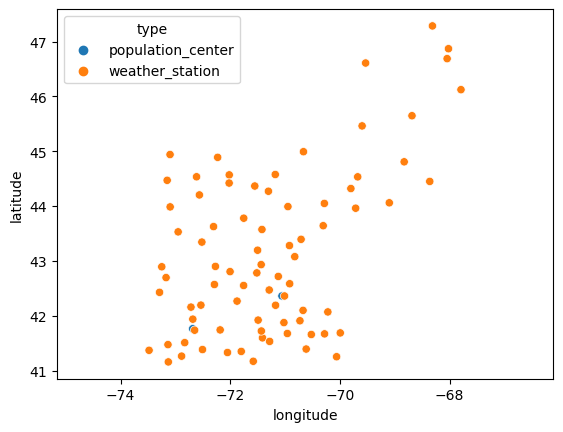

In [9]:
sns.scatterplot(all_coords, x='longitude', y='latitude', hue='type')
plt.axis('equal')

In [10]:
all_coords

,latitude,longitude,type
0,42.361145,-71.05708,population_center
1,41.763710,-72.68510,population_center
2,42.191200,-71.17330,weather_station
3,43.985500,-73.09550,weather_station
4,41.741900,-72.18360,weather_station
...,...,...,...
77,42.098200,-70.67210,weather_station
78,42.570100,-72.28860,weather_station
79,41.158300,-73.12890,weather_station
80,42.893500,-73.24860,weather_station


<Axes: xlabel='longitude', ylabel='latitude'>

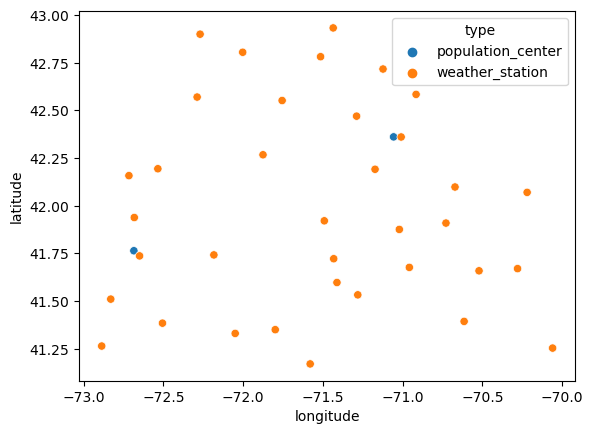

In [11]:
relevant_points = all_coords[(all_coords['latitude'].between(41, 43)) & (all_coords['longitude'].between(-73, -70))]
sns.scatterplot(relevant_points, x='longitude', y='latitude', hue='type')

In [12]:
c = cdist(relevant_points.loc[relevant_points['type'] == 'weather_station', ['longitude', 'latitude']], relevant_points.loc[relevant_points['type'] == 'population_center', ['longitude', 'latitude']], 'euclidean')
distances = pd.DataFrame(c, columns=['distance_to_boston', 'distance_to_hartford'])

In [13]:
distances

,distance_to_boston,distance_to_hartford
0,0.205884,1.571078
1,1.285501,0.501974
2,1.431485,0.769062
3,0.621658,1.551164
4,1.710384,0.044766
5,0.883491,2.166157
6,0.685669,1.711073
7,1.747595,0.419962
8,1.490414,2.674004
9,0.724291,1.218541


(-0.05692527596842474,
 2.2378597520050385,
 -0.08669548755736906,
 2.8054659234720445)

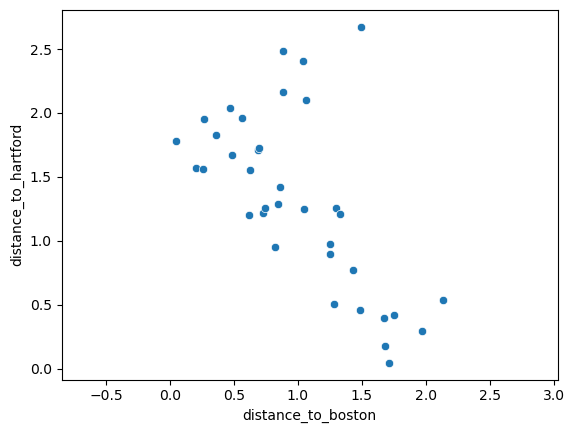

In [14]:
g = sns.scatterplot(distances, x='distance_to_boston', y='distance_to_hartford')
plt.axis('equal')

In [15]:
X = distances.to_numpy()

In [16]:
distortions = []
inertias = []
silhouettes = []
mapping1 = {}
mapping2 = {}
mapping3 = {}
labels = {}

cluster_amount = range(2, 15)
for n in cluster_amount:
    kmeans = KMeans(n_clusters=n, n_init=10)
    kmeans.fit(X)
    silhouettes.append(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeans.inertia_)
    mapping1[n] = sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    mapping2[n] = kmeans.inertia_
    mapping3[n] = metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')
    labels[n] = kmeans.labels_

<Axes: >

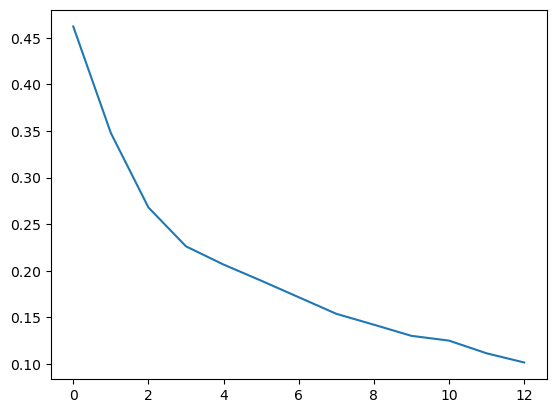

In [17]:
sns.lineplot(distortions)

<Axes: >

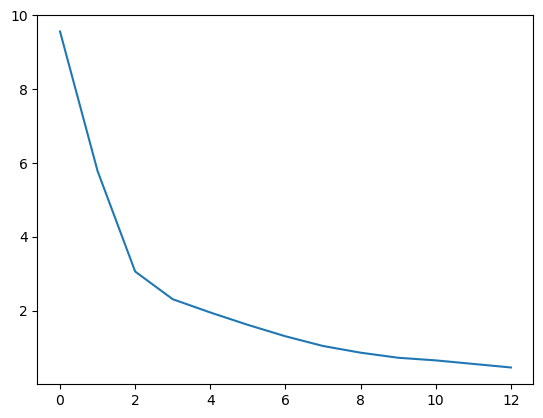

In [18]:
sns.lineplot(inertias)

<Axes: >

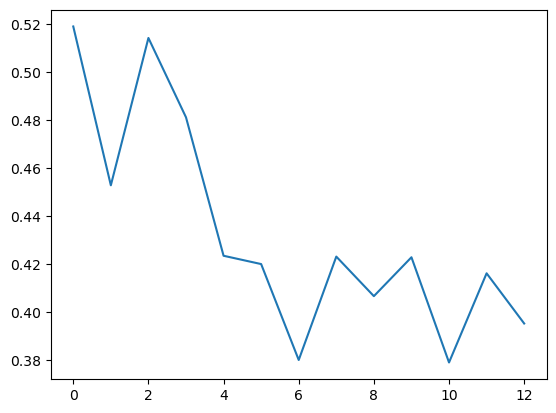

In [19]:
sns.lineplot(silhouettes)

In [20]:
labels[2]

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int32)

In [21]:
relevant_points['label'] = 'population_center'
relevant_points.loc[2:, 'label'] = labels[2]
relevant_points

/tmp/ipykernel_12342/1591246521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_points['label'] = 'population_center'


,latitude,longitude,type,label
0,42.361145,-71.05708,population_center,population_center
1,41.763710,-72.68510,population_center,population_center
2,42.191200,-71.17330,weather_station,0
4,41.741900,-72.18360,weather_station,1
7,41.330000,-72.05000,weather_station,1
8,42.781800,-71.51480,weather_station,0
9,41.736700,-72.64940,weather_station,1
10,41.658500,-70.52150,weather_station,0
11,42.932800,-71.43570,weather_station,0
15,41.383900,-72.50590,weather_station,1


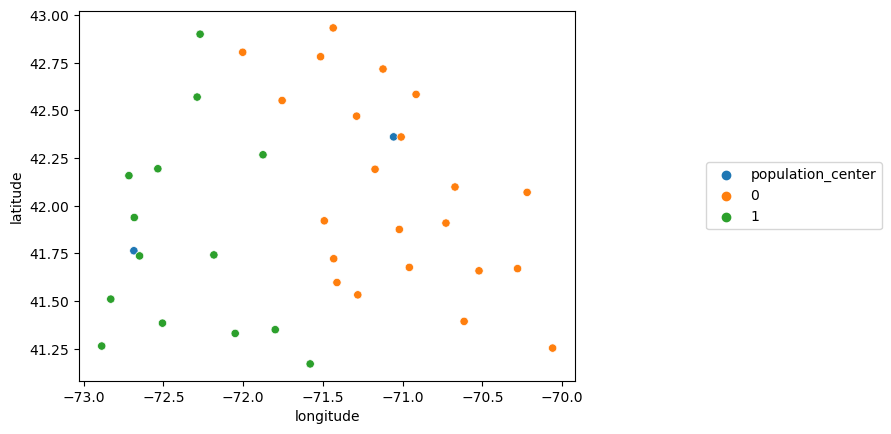

In [22]:
g = sns.scatterplot(relevant_points, x='longitude', y='latitude', hue='label')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [23]:
hartford_area = tuple(relevant_points.loc[relevant_points['label'] == 1, ['latitude', 'longitude']].itertuples(index=False, name=None))
boston_area = tuple(relevant_points.loc[relevant_points['label'] == 0, ['latitude', 'longitude']].itertuples(index=False, name=None))
area_params = [boston_area, hartford_area]

In [22]:
dfs = list()

with engine.connect() as conn:
    for params in area_params:
        values = ", ".join(str((str(lat), str(lon))) for (lat, lon) in params)
        stmt = '''SELECT 
            weather_datetime, 
            AVG(NULLIF(apparent_temperature, 'NaN')) apparent_temperature_avg, 
            AVG(NULLIF(air_temperature, 'NaN')) air_temperature_avg, 
            AVG(NULLIF(dewpoint_temperature, 'NaN')) dewpoint_temperature_avg,
            AVG(NULLIF(relative_humidity, 'NaN')) relative_humidity_avg,
            AVG(NULLIF(total_precipitation, 'NaN')) total_precipitation_avg, 
            AVG(NULLIF(wind_speed, 'NaN')) wind_speed_avg
            FROM weather_historical
            WHERE (latitude, longitude) IN ({})
            GROUP BY weather_datetime
            ORDER BY weather_datetime ASC;'''.format(values)
        df = pd.read_sql(sql=text(stmt), con=conn)
        dfs.append(df)

In [23]:
with engine.connect() as conn:
    load_historical = pd.read_sql(sql=text("SELECT DISTINCT load_datetime, load_mw FROM grid_load;"), con=conn)

In [24]:
stmt = """SELECT DISTINCT gf.forecasted_at, gf.forecasted_for, gf.load_mw FROM grid_forecast gf 
INNER JOIN (SELECT MAX(forecasted_at) MaxDate, forecasted_for FROM grid_forecast group by forecasted_for) tm
ON tm.forecasted_for = gf.forecasted_for AND gf.forecasted_at = tm.MaxDate;"""
with engine.connect() as conn:
    load_forecast = pd.read_sql(sql=text(stmt), con=conn)

In [25]:
boston_area_weather = dfs[0].rename(columns={c:'boston_area_'+c for c in dfs[0].columns if c not in ['weather_datetime']})
hartford_area_weather = dfs[1].rename(columns={c:'hartford_area_'+c for c in dfs[1].columns if c not in ['weather_datetime']})

In [26]:
two_cluster_weather = boston_area_weather.merge(hartford_area_weather, on='weather_datetime', how='inner')
two_cluster_weather['weather_datetime'] = two_cluster_weather['weather_datetime'].astype('datetime64')

In [31]:
data = (
    two_cluster_weather
    .merge(
        load_historical, 
        left_on='weather_datetime', 
        right_on='load_datetime', 
        how='inner', indicator=True)
    .drop(columns=['_merge', 'weather_datetime'])
)

In [43]:
os.listdir('work/New-England-Load-Forecasting/')

['.git', 'New-England-Load-Forecasting']

In [28]:
load_forecast.to_csv('work/New-England-Load-Forecasting/analysis/official_forecasts.csv')

In [25]:
load_forecast = pd.read_csv('../analysis/official_forecasts.csv', index_col=0)
load_forecast[['forecasted_at', 'forecasted_for']] = load_forecast[['forecasted_at', 'forecasted_for']].apply(pd.to_datetime)

In [7]:
data = pd.read_csv('../analysis/clean_data.csv', index_col=0)

In [29]:
data = pd.read_csv('work/New-England-Load-Forecasting/analysis/clean_data.csv', index_col=0)

In [8]:
data['load_datetime'] = pd.to_datetime(data['load_datetime'])
data['is_weekday'] = np.where(data['load_datetime'].dt.dayofweek >= 5, 0, 1)

In [142]:
data

,boston_area_apparent_temperature_avg,boston_area_air_temperature_avg,boston_area_dewpoint_temperature_avg,boston_area_relative_humidity_avg,boston_area_total_precipitation_avg,boston_area_wind_speed_avg,hartford_area_apparent_temperature_avg,hartford_area_air_temperature_avg,hartford_area_dewpoint_temperature_avg,hartford_area_relative_humidity_avg,hartford_area_total_precipitation_avg,hartford_area_wind_speed_avg,load_datetime,load_mw,is_weekday
0,32.062857,38.142858,32.914285,81.734286,0.520000,9.019524,34.165714,38.477143,36.062143,91.049999,1.905714,6.956429,2019-01-01 01:00:00,11496.656,1
1,31.107143,37.592858,34.339524,88.272858,1.558571,9.614762,32.799286,38.524286,36.746429,93.399285,4.116429,9.440000,2019-01-01 02:00:00,11368.765,1
2,30.134286,37.329524,34.856190,90.816666,3.059524,11.066667,33.081429,39.167857,37.264285,92.940000,4.355714,10.520000,2019-01-01 03:00:00,11270.259,1
3,30.843333,38.037143,35.559047,91.044762,3.000476,11.940952,34.318572,39.656428,38.322857,95.037857,6.132857,9.850000,2019-01-01 04:00:00,11309.606,1
4,31.741500,38.882500,36.663500,92.064500,5.599000,12.382500,35.850000,40.370714,39.013572,94.942143,5.570000,9.125714,2019-01-01 05:00:00,11516.118,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37019,52.330476,53.761905,42.754762,68.240953,0.057727,11.829048,50.293076,51.110769,46.752308,85.290769,0.780714,10.232857,2023-03-23 19:00:00,13881.286,1
37020,49.870476,51.921428,44.487143,77.743809,0.207273,12.129524,49.656154,50.735384,47.620770,89.139231,0.432143,9.624286,2023-03-23 20:00:00,13472.341,1
37021,49.795238,51.688096,46.388095,83.216191,0.264545,11.782857,50.168461,51.066923,47.878462,89.037693,0.017857,9.132143,2023-03-23 21:00:00,12674.921,1
37022,49.491905,51.505714,46.634286,84.262857,0.000000,11.681905,50.516153,51.446153,48.230770,88.896154,0.000000,9.528571,2023-03-23 22:00:00,11677.522,1


In [143]:
prophet_train = data.loc[data['load_datetime'] <= '2023-03-10',:].rename({'load_datetime': 'ds', 'load_mw': 'y'}, axis=1).sort_values('ds')
prophet_test = data.loc[data['load_datetime'] > '2023-03-10',:].rename({'load_datetime': 'ds', 'load_mw': 'y'}, axis=1).sort_values('ds')

In [144]:
prophet_train

,boston_area_apparent_temperature_avg,boston_area_air_temperature_avg,boston_area_dewpoint_temperature_avg,boston_area_relative_humidity_avg,boston_area_total_precipitation_avg,boston_area_wind_speed_avg,hartford_area_apparent_temperature_avg,hartford_area_air_temperature_avg,hartford_area_dewpoint_temperature_avg,hartford_area_relative_humidity_avg,hartford_area_total_precipitation_avg,hartford_area_wind_speed_avg,ds,y,is_weekday
0,32.062857,38.142858,32.914285,81.734286,0.520000,9.019524,34.165714,38.477143,36.062143,91.049999,1.905714,6.956429,2019-01-01 01:00:00,11496.656,1
1,31.107143,37.592858,34.339524,88.272858,1.558571,9.614762,32.799286,38.524286,36.746429,93.399285,4.116429,9.440000,2019-01-01 02:00:00,11368.765,1
2,30.134286,37.329524,34.856190,90.816666,3.059524,11.066667,33.081429,39.167857,37.264285,92.940000,4.355714,10.520000,2019-01-01 03:00:00,11270.259,1
3,30.843333,38.037143,35.559047,91.044762,3.000476,11.940952,34.318572,39.656428,38.322857,95.037857,6.132857,9.850000,2019-01-01 04:00:00,11309.606,1
4,31.741500,38.882500,36.663500,92.064500,5.599000,12.382500,35.850000,40.370714,39.013572,94.942143,5.570000,9.125714,2019-01-01 05:00:00,11516.118,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36687,41.714762,46.309524,27.561905,48.942857,0.000000,12.622381,45.479285,48.307143,23.985715,38.760715,0.000000,10.390714,2023-03-09 20:00:00,14271.569,1
36688,39.754762,45.161905,28.040476,52.167619,0.000000,12.184286,43.821429,47.450000,24.414286,40.679286,0.000000,10.965714,2023-03-09 21:00:00,13514.556,1
36689,38.217143,43.628571,28.642857,56.708571,0.000000,10.094286,41.717857,45.978572,25.042857,44.253572,0.000000,10.487143,2023-03-09 22:00:00,12570.870,1
36690,35.684500,41.120000,29.261905,63.436666,0.000000,8.568000,38.585714,43.100000,24.971429,49.385714,0.000000,8.570000,2023-03-09 23:00:00,11752.578,1


In [10]:
import itertools
from prophet.diagnostics import performance_metrics, cross_validation
param_grid = {
    'changepoint_prior_scale': [.001, .01, .1, .5],
    'seasonality_prior_scale': [.01, .1, 1, 10, 100]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

In [11]:
for params in all_params:
    m = Prophet(**params)
    m.add_country_holidays(country_name='US')
    m.add_regressor('boston_area_apparent_temperature_avg')
    m.add_regressor('hartford_area_apparent_temperature_avg')
    m.add_regressor('is_weekday')
    m.fit(prophet_train)
    df_cv = cross_validation(m, initial='1460 days', horizon='7 days', period='24 hours', parallel='threads')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

14:03:10 - cmdstanpy - INFO - Chain [1] start processing
14:03:19 - cmdstanpy - INFO - Chain [1] done processing
14:04:01 - cmdstanpy - INFO - Chain [1] start processing
14:04:03 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:06 - cmdstanpy - INFO - Chain [1] start processing
14:04:06 - cmdstanpy - INFO - Chain [1] start processing
14:04:06 - cmdstanpy - INFO - Chain [1] start processing
14:04:06 - cmdstanpy - INFO - Chain [1] start processing
14:04:06 - cmdstanpy - INFO - Chain [1] start processing
14:04:08 - cmdstanpy - INFO - Chain [1] start processing
14:04:08 - cmdstanpy - INFO - Chain [1] start processing
14:04:08 - cmdstanpy - INFO - Ch

In [19]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
7,0.010,1.00,1307.354973
8,0.010,10.00,1307.446563
9,0.010,100.00,1307.596521
6,0.010,0.10,1307.746674
5,0.010,0.01,1308.074677
0,0.001,0.01,1346.818373
3,0.001,10.00,1347.792355
4,0.001,100.00,1347.935723
1,0.001,0.10,1348.102440
2,0.001,1.00,1348.180836


In [121]:
merged_predictions

,yhat,y,iso_forecast
ds,,,
2023-03-10 01:00:00,11103.859433,11533.529,11320.0
2023-03-10 02:00:00,10920.077003,11838.865,11230.0
2023-03-10 03:00:00,10883.071879,11773.357,11270.0
2023-03-10 04:00:00,11068.896920,12081.785,11590.0
2023-03-10 05:00:00,11492.060324,12394.378,12550.0
...,...,...,...
2023-03-23 19:00:00,13541.496141,13881.286,13940.0
2023-03-23 20:00:00,13033.596483,13472.341,13450.0
2023-03-23 21:00:00,12224.422058,12674.921,12630.0


In [124]:
(((merged_predictions['y'] - merged_predictions['iso_forecast']) ** 2)**.5).mean()

388.33027409638555

In [123]:
(((merged_predictions['y'] - merged_predictions['yhat']) ** 2)**.5).mean()

1040.8561820137024

In [20]:
best_params = all_params[np.argmin(rmses)]
best_params

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1}

In [147]:
regressors = [c for c in prophet_train.columns if c not in ['ds', 'y']]

In [178]:
regressors

['boston_area_apparent_temperature_avg',
 'boston_area_air_temperature_avg',
 'boston_area_dewpoint_temperature_avg',
 'boston_area_relative_humidity_avg',
 'boston_area_total_precipitation_avg',
 'boston_area_wind_speed_avg',
 'hartford_area_apparent_temperature_avg',
 'hartford_area_air_temperature_avg',
 'hartford_area_dewpoint_temperature_avg',
 'hartford_area_relative_humidity_avg',
 'hartford_area_total_precipitation_avg',
 'hartford_area_wind_speed_avg',
 'is_weekday']

In [170]:
m = Prophet(**best_params)
m.add_country_holidays(country_name='US')
for col in regressors:
    m.add_regressor(col)
m.fit(prophet_train)

13:31:21 - cmdstanpy - INFO - Chain [1] start processing
13:31:34 - cmdstanpy - INFO - Chain [1] done processing


In [171]:
predictions = m.predict(prophet_test)

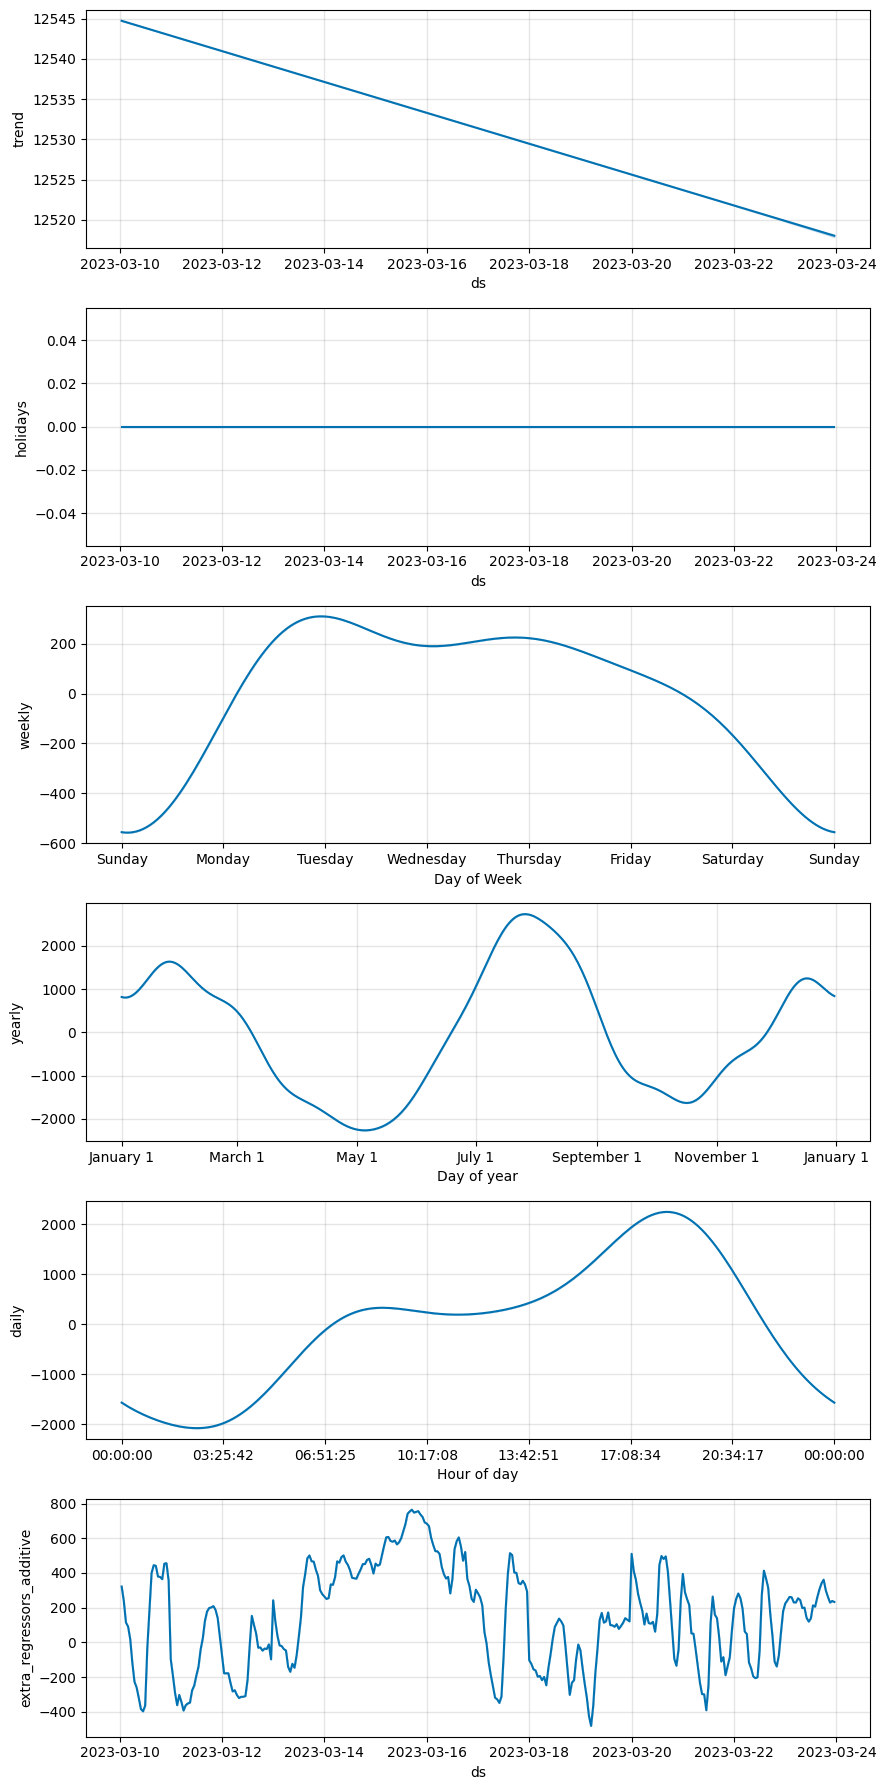

In [172]:
fig = m.plot_components(predictions)

<Axes: xlabel='hour'>

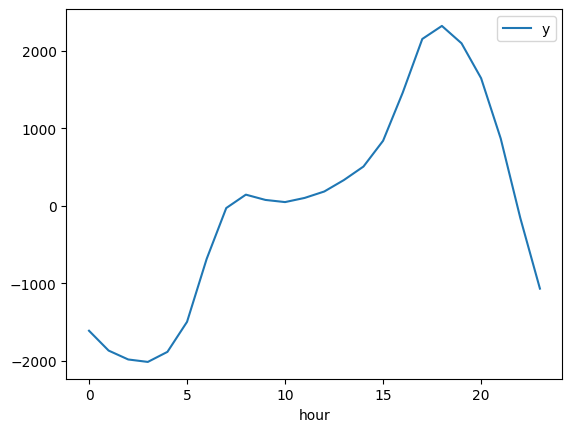

In [173]:
prophet_train['hour'] = prophet_train['ds'].dt.hour
((prophet_train[['hour', 'y']].groupby('hour').agg('mean'))-(prophet_train[['hour', 'y']].groupby('hour').agg('mean')).mean()).plot()

In [174]:
merged_predictions = predictions[['ds', 'yhat']].merge(prophet_test[['y', 'ds']]).merge(load_forecast[['load_mw', 'forecasted_for']].rename(columns={'load_mw': 'iso_forecast', 'forecasted_for': 'ds'}), on='ds').set_index('ds')
merged_predictions

,yhat,y,iso_forecast
ds,,,
2023-03-10 01:00:00,10975.096404,11533.529,11320.0
2023-03-10 02:00:00,10707.422774,11838.865,11230.0
2023-03-10 03:00:00,10570.962402,11773.357,11270.0
2023-03-10 04:00:00,10791.903746,12081.785,11590.0
2023-03-10 05:00:00,11233.103882,12394.378,12550.0
...,...,...,...
2023-03-23 19:00:00,13918.109812,13881.286,13940.0
2023-03-23 20:00:00,13296.824714,13472.341,13450.0
2023-03-23 21:00:00,12341.910428,12674.921,12630.0


In [175]:
(((merged_predictions['y']-merged_predictions['yhat'])**2)**.5).mean()

1062.7078055637662

In [71]:
((merged_predictions[:'2023-03-20']['y'] - merged_predictions[:'2023-03-20']['yhat']) < (merged_predictions[:'2023-03-20']['y'] - merged_predictions[:'2023-03-20']['iso_forecast'])).value_counts()

False    13
True     10
dtype: int64

<Axes: xlabel='ds'>

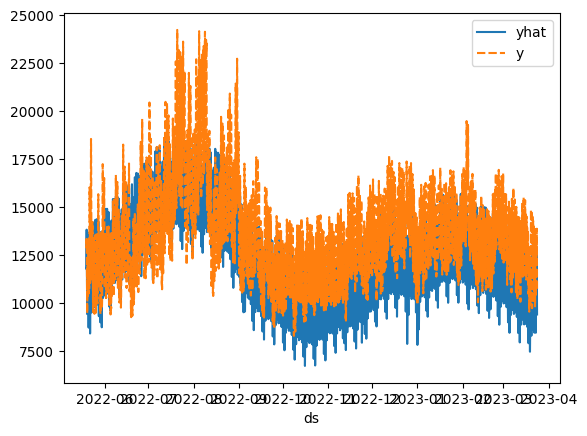

In [72]:
sns.lineplot(merged_y_yhat)

In [51]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-05-19 10:00:00,12648.668211,10046.587328,13567.149176,12648.668211,12648.668211,0.0,0.0,0.0,0.0,...,233.259529,233.259529,233.259529,-1716.255273,-1716.255273,-1716.255273,0.0,0.0,0.0,11835.692309
1,2022-05-19 11:00:00,12648.441904,9888.312901,13530.104471,12648.441904,12648.441904,0.0,0.0,0.0,0.0,...,227.453181,227.453181,227.453181,-1713.741283,-1713.741283,-1713.741283,0.0,0.0,0.0,11790.086321
2,2022-05-19 12:00:00,12648.215597,10170.491367,13513.653830,12648.215597,12648.215597,0.0,0.0,0.0,0.0,...,221.259015,221.259015,221.259015,-1711.218789,-1711.218789,-1711.218789,0.0,0.0,0.0,11842.134383
3,2022-05-19 13:00:00,12647.989291,10225.408691,13702.879073,12647.989291,12647.989291,0.0,0.0,0.0,0.0,...,214.725061,214.725061,214.725061,-1708.687806,-1708.687806,-1708.687806,0.0,0.0,0.0,11978.674234
4,2022-05-19 14:00:00,12647.762984,10419.968719,13802.275666,12647.762984,12647.762984,0.0,0.0,0.0,0.0,...,207.898860,207.898860,207.898860,-1706.148348,-1706.148348,-1706.148348,0.0,0.0,0.0,12189.353706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7399,2023-03-23 19:00:00,10973.770709,2271.715040,21778.907783,419.928790,19976.388934,0.0,0.0,0.0,0.0,...,170.900160,170.900160,170.900160,-1073.701535,-1073.701535,-1073.701535,0.0,0.0,0.0,12732.469586
7400,2023-03-23 20:00:00,10973.544402,1332.098645,21165.461283,415.969683,19977.910852,0.0,0.0,0.0,0.0,...,163.179898,163.179898,163.179898,-1075.733095,-1075.733095,-1075.733095,0.0,0.0,0.0,12136.100654
7401,2023-03-23 21:00:00,10973.318095,989.727646,20272.858510,412.010575,19979.432769,0.0,0.0,0.0,0.0,...,155.414513,155.414513,155.414513,-1077.759650,-1077.759650,-1077.759650,0.0,0.0,0.0,11209.278897
7402,2023-03-23 22:00:00,10973.091788,-498.804782,19292.367560,408.051468,19980.954687,0.0,0.0,0.0,0.0,...,147.618755,147.618755,147.618755,-1079.781204,-1079.781204,-1079.781204,0.0,0.0,0.0,10221.880239


In [53]:
prophet_test

,ds,boston_area_apparent_temperature_avg,hartford_area_apparent_temperature_avg,y,is_weekday
29620,2022-05-19 10:00:00,54.828572,52.665833,13117.797,1
29621,2022-05-19 11:00:00,54.890477,52.884615,13199.001,1
29622,2022-05-19 12:00:00,55.145455,52.942307,13205.589,1
29623,2022-05-19 13:00:00,55.404546,53.140769,13116.635,1
29624,2022-05-19 14:00:00,55.382273,53.659230,12934.000,1
...,...,...,...,...,...
37019,2023-03-23 19:00:00,52.330476,50.293076,13881.286,1
37020,2023-03-23 20:00:00,49.870476,49.656154,13472.341,1
37021,2023-03-23 21:00:00,49.795238,50.168461,12674.921,1
37022,2023-03-23 22:00:00,49.491905,50.516153,11677.522,1
